In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from utils import OCRTokenizer, OCRDataset, collate_batch, save_experiment_info

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchinfo

In [93]:
!wget https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip && unzip -q captcha_images_v2.zip

--2023-04-05 05:31:41--  https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip [following]
--2023-04-05 05:31:41--  https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9075967 (8.7M) [application/zip]
Saving to: ‘captcha_images_v2.zip’

captcha_images_v2.z 100%[===================>]   8.66M  --.-KB/s    in 0.09s   

2023-04-05 05:31:42 (94.2 MB/s) - ‘captcha_images_v2.zip’

In [2]:
tokenizer = OCRTokenizer('./synthetic_dataset/train/labels.txt')
tokenizer.counter.most_common(5)

[(' ', 10061), ('8', 3028), ('S', 3012), ('b', 3006), ('V', 2992)]

In [3]:
train_dataset = OCRDataset('./synthetic_dataset/train/', tokenizer, do_train_transform=True, image_size=(384, 384))  # need quadratic images for vit, 64 h for others
val_dataset = OCRDataset('./synthetic_dataset/val/', tokenizer, do_train_transform=False, image_size=(384, 384))
test_dataset = OCRDataset('./synthetic_dataset/test/', tokenizer, do_train_transform=False, image_size=(384, 384))
test_captchas_dataset = OCRDataset('./synthetic_dataset/test_captchas/', tokenizer, do_train_transform=False, image_size=(384, 384))
len(train_dataset), len(val_dataset), len(test_dataset), len(test_captchas_dataset)

(20000, 1500, 5000, 5000)

In [4]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')
model

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=76

In [5]:
torchinfo.summary(model)

Layer (type:depth-idx)                                       Param #
VisionEncoderDecoderModel                                    --
├─ViTModel: 1-1                                              --
│    └─ViTEmbeddings: 2-1                                    443,904
│    │    └─ViTPatchEmbeddings: 3-1                          590,592
│    │    └─Dropout: 3-2                                     --
│    └─ViTEncoder: 2-2                                       --
│    │    └─ModuleList: 3-3                                  85,026,816
│    └─LayerNorm: 2-3                                        1,536
│    └─ViTPooler: 2-4                                        --
│    │    └─Linear: 3-4                                      590,592
│    │    └─Tanh: 3-5                                        --
├─TrOCRForCausalLM: 1-2                                      --
│    └─TrOCRDecoderWrapper: 2-5                              --
│    │    └─TrOCRDecoder: 3-6                                247,268,352


In [6]:
processor((test_dataset[1]['image']*255).to(torch.uint8)).pixel_values[0].shape

(3, 384, 384)

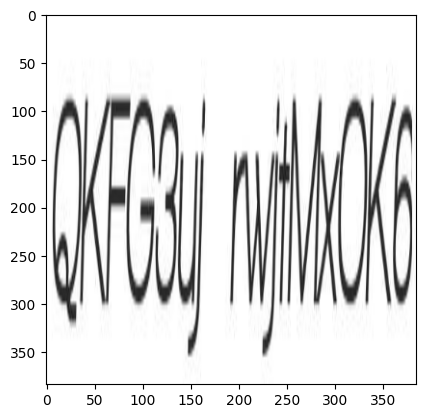

In [89]:
test_image = test_dataset[np.random.randint(0, len(test_captchas_dataset))]['image']
plt.imshow(test_image.permute(1, 2, 0))

In [41]:
test_dataset[0]['image'].shape

torch.Size([3, 384, 384])

In [60]:
processor.tokenizer

PreTrainedTokenizerFast(name_or_path='microsoft/trocr-base-printed', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [90]:
generated_ids = model.generate(test_image.unsqueeze(0))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [91]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text

['QKFG3UJ NYTMXOK6']